In [1]:
import tensorflow
import numpy as np
import os
from PIL import Image, ImageChops, ImageEnhance
import PIL
import glob
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 

# Przygotowanie mapowania kategorii

In [2]:
#mapping
TRAIN_DIR = 'C:\messier_detection\data_110\categories_110'
LABELS_DIR = [ x for x in os.listdir(TRAIN_DIR) ]
LABELS  = [n+1 for n in range(len(LABELS_DIR))]

labels_to_num_dict = dict(zip(LABELS_DIR, LABELS))
num_to_labels_dict = dict(zip(LABELS, LABELS_DIR))

In [3]:
len(num_to_labels_dict)

110

In [4]:
def define_aug(aug, image):
    return aug(image=image)['image']

# Przekształcenia obrazu

In [5]:
def transform_pattern(open_img):
    rand_transfrom = random.randint(0,3) 
    float_number_bright = random.uniform(0.85, 1.40)
    open_img = ImageEnhance.Brightness(open_img).enhance(float_number_bright)
    
    if rand_transfrom == 0:
        open_img = open_img.transpose(Image.ROTATE_90)
    if rand_transfrom == 1:
        open_img = open_img.transpose(Image.ROTATE_180)
    if rand_transfrom == 2:
        open_img = open_img.transpose(Image.ROTATE_270)

    return open_img

In [6]:
def generate_background_from_catalog(list_of_paths, canvas_size):
    path_to_background = random.choice(list_of_paths)
    open_img = Image.open(path_to_background).convert('RGB')
    float_number_bright = random.uniform(0.8, 1.3)
    float_number_contrast = random.uniform(0.4, 1.1)
    open_img = ImageEnhance.Contrast(open_img).enhance(float_number_contrast)
    open_img = ImageEnhance.Brightness(open_img).enhance(float_number_bright)
    open_img = open_img.resize(canvas_size)
    open_img = transform_pattern(open_img)
    
    black = (0,0,0)
    canvas = Image.new('RGB', (canvas_size), black)
    
    return canvas

# Zdefiniowanie przekształceń oraz sposobu generowania zbioru

In [7]:
import random
import glob
from albumentations import (
RandomScale,
RandomRotate90,
RandomCrop,
BboxParams,
Compose    
)


background_paths = glob.glob('C:\\mgr_detekcja\\background\\*') 

def generate_patterns_dict(path_patterns_list):
    patterns_dict = dict()   
    for path_to_pattern in path_patterns_list:
        category = os.path.split(path_to_pattern)[1] 
        patterns_dict[category] = []     
        files_paths = glob.glob(path_to_pattern+'\*')
        
        for i, path_to_one_file in enumerate(files_paths):
            open_img = Image.open(path_to_one_file).convert('RGB')
            
            patterns_dict[category].append(open_img)
    return patterns_dict

def generate_canvas_image(patterns_dict, canvas_size, max_image_size, fill):
    canvas = generate_background_from_catalog(background_paths, canvas_size)
    canvas_w, canvas_h = canvas.size
    grid = int(canvas_size[0]/max_image_size[0])
    bboxes = []
    category = []
    for i in range(grid):
        for j in range(grid):
            value = random.randint(1,10)
            if (value > fill):
                continue

            messier_category, files_for_pattern = random.choice(list(patterns_dict.items()))
            messier_img = random.choice(files_for_pattern)            
            messier_img = transform_pattern(messier_img)

            messier_img.thumbnail((max_image_size))
            w, h = messier_img.size
            canvas.paste(messier_img, (i*max_image_size[0],j*max_image_size[0]))
            #coco notation
            w, h = messier_img.size
            bboxes.append([0.3333*w,0.3333*h,0.3333*w, 0.3333*h]) 
            #bboxes.append([0.25*w,0.25*h,0.50*w, 0.50*h]) #dla 30x30
            category.append(messier_category)   
            
    return canvas, bboxes, category

# Wczytanie obiektów z przygotowanych folderów ( zał. 1)

In [8]:
data_list = glob.glob('C:\messier_detection\data_110_k\medium_45\*')
patterns_dict = generate_patterns_dict(data_list)

In [9]:
len(patterns_dict)

105

In [10]:
bbox_params = BboxParams(
  format='coco',
  min_area=1,
  min_visibility=0.8,
  label_fields=['category']
)

# Zdefiniowanie wymiarów elementu, sposobu wypełnienia i liczebności zbioru

In [11]:
from tqdm import tqdm
canvas_numpy_training_list = []
max_image_size = (1600,1600)
canvas_size = (1600,1600)

for i in tqdm(range(3000)):
    canvas, bboxes, category = generate_canvas_image(patterns_dict, canvas_size, max_image_size, fill = 10)  
    canvas_numpy = np.array(canvas)
    annotations = {'image': canvas_numpy, 'bboxes': bboxes, 'category': category}

    rand_crop = Compose([
    RandomCrop(int(0.75*max_image_size[0]), int(0.75*max_image_size[1]), p=0.7)
], bbox_params=bbox_params)
    

    cropped_img = rand_crop(**annotations) 
    canvas_numpy_training_list.append(cropped_img)
    

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [13:15<00:00,  3.77it/s]


# Zapisanie obrazów oraz elementów w formacie COCO w pliku .csv

In [13]:
data_set_path = 'C:/messier_detection/zbior_45x45/medium_45_all_simbad'
data_frame_set = pd.DataFrame()

for counter, elem in enumerate(tqdm(canvas_numpy_training_list)):     
    img = Image.fromarray(elem['image'])
    img.save(os.path.join(data_set_path,str(counter)+'.jpg'))
    bboxes = elem['bboxes']
    categories = elem['category']
    img_width, img_height = img.size
    img_name = str(counter)+'.jpg'
    
    for bbox, category in zip(bboxes, categories):
        data_frame_set = data_frame_set.append({'img_file': img_name, 
                'img_width': img_width, 'img_height': img_height, 'category': category, 'xmin': bbox[0], 
                'xmax': bbox[0]+bbox[2], 'ymin': bbox[1], 'ymax': bbox[1]+bbox[3]}, ignore_index=True)    
    

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:48<00:00, 13.12it/s]


In [14]:
data_frame_set[['img_height', 'img_width', 'xmax', 'xmin', 'ymax', 'ymin']] =  data_frame_set[['img_height', 'img_width', 'xmax', 'xmin', 'ymax', 'ymin']].astype(int)

data_frame_set.to_csv(os.path.join(data_set_path,'set_45x45.csv'))

In [16]:
data_frame_set['category'].nunique()

105

# Wizualizacja elementów

In [17]:
import cv2
RECTANGLE_COLOR = (255, 255, 255)
#BOX_COLOR = (255,255,255)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_name, color=RECTANGLE_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), thickness=thickness, color=color) 
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_DUPLEX   , 1.5, 0)   
    cv2.putText(img, class_name, (x_min, y_max - int(0.5 * text_height)), cv2.FONT_HERSHEY_DUPLEX   , 1.5,TEXT_COLOR, lineType=cv2.FILLED)
    return img

In [18]:
def visualize(annotations, id_to_name_mapping):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category'][idx])
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

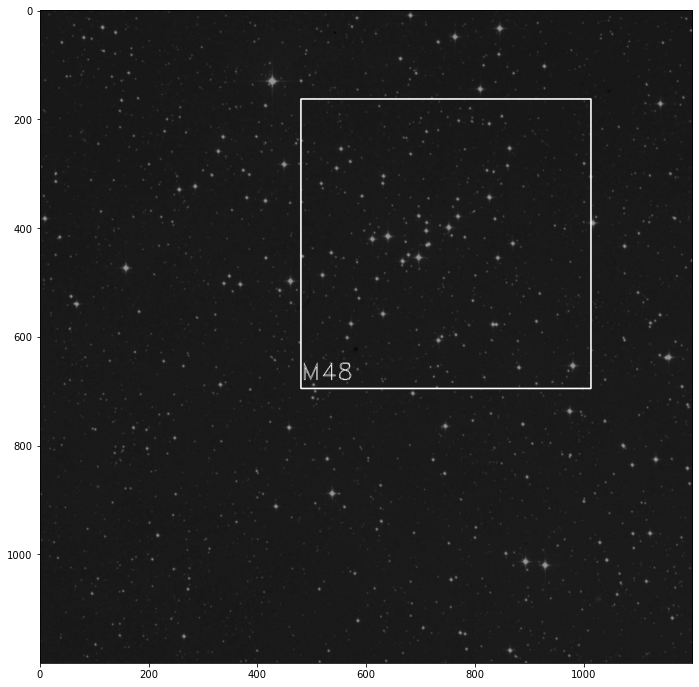

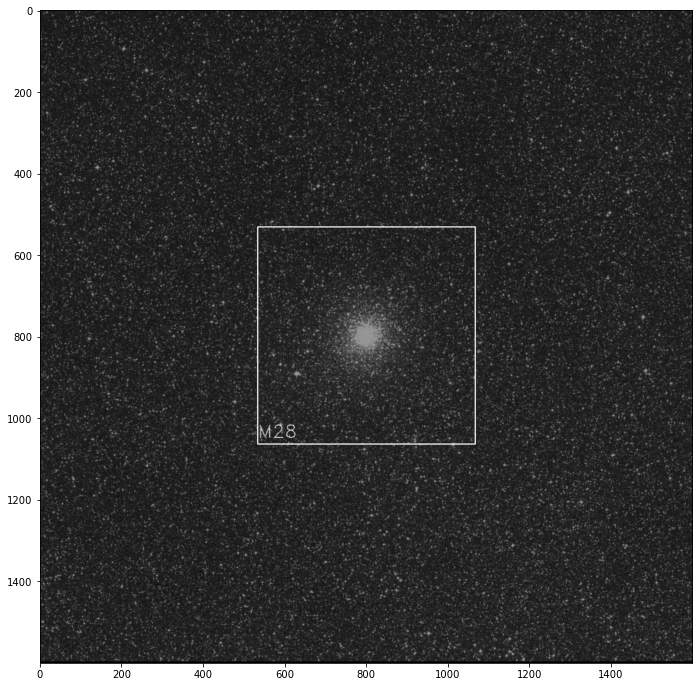

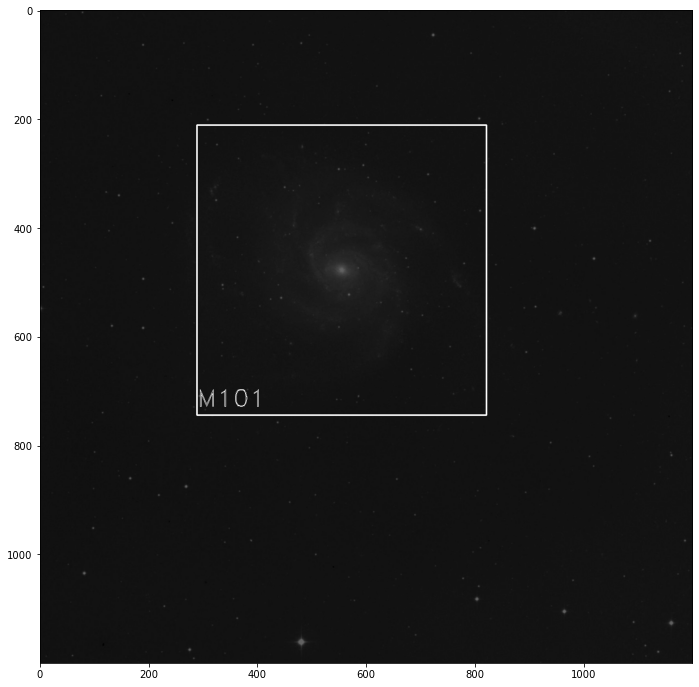

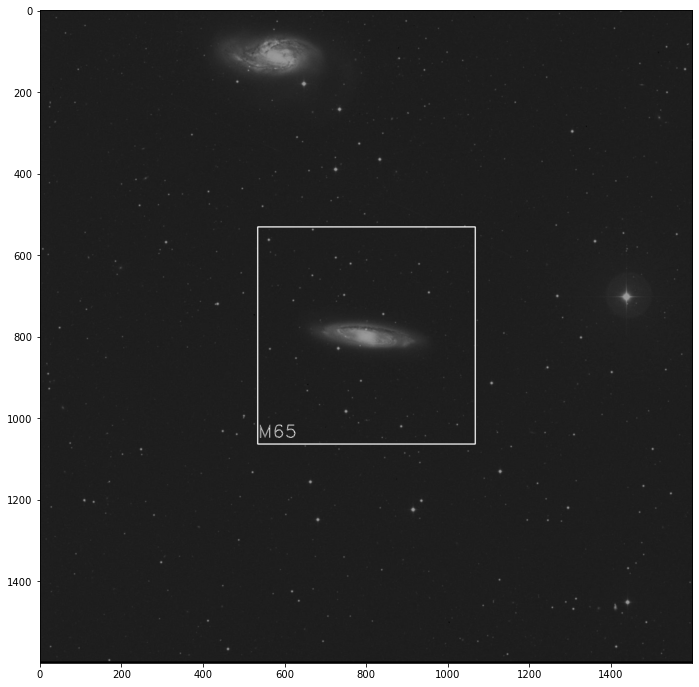

In [20]:
for i  in range(4):
    visualize(canvas_numpy_training_list[i], num_to_labels_dict)